# Задание
Для заданного набора данных решите задачу кластеризации с использованием методов 1) K-Means, 2) DBSCAN и 3) Birch. Оцените качество модели на основе подходящих метрик качества (не менее двух метрик, если это возможно). Какие метрики качества Вы использовали и почему? Какие выводы Вы можете сделать о качестве построенных моделей?<cite data-cite="ue:rk2"></cite>.

# Решение

## Импорт библиотек

Импортируем библиотеки с помощью команды import.

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import adjusted_rand_score
from sklearn.metrics import adjusted_mutual_info_score
from sklearn.metrics import homogeneity_completeness_v_measure
from sklearn.metrics import silhouette_score
from sklearn.cluster import KMeans
from sklearn.cluster import DBSCAN
from sklearn.cluster import Birch

In [2]:
warnings.simplefilter(action='ignore', category=FutureWarning)

Настроим отображение графиков<cite data-cite="doc:ipython,doc:seaborn"></cite>:

In [3]:
# Enable inline plots
%matplotlib inline

# Set plot style
sns.set(style="ticks")

# Set plots formats to save high resolution PNG
from IPython.display import set_matplotlib_formats
set_matplotlib_formats("retina")

Зададим ширину текстового представления данных, чтобы в дальнейшем текст в отчёте влезал на А4<cite data-cite="doc:pandas"></cite>:

In [4]:
pd.set_option("display.width", 70)

## Загрузка данных

В качестве набора данных будем использовать датасет `iris`<cite data-cite="kg:iris"></cite>:

In [5]:
data = pd.read_csv('iris.csv')

## Основные характеристики датасета

In [6]:
data.head()

,SepalLengthCm,SepalWidthCm,PetalLengthCm,PetalWidthCm,Species
0,5.1,3.5,1.4,0.2,Iris-setosa
1,4.9,3.0,1.4,0.2,Iris-setosa
2,4.7,3.2,1.3,0.2,Iris-setosa
3,4.6,3.1,1.5,0.2,Iris-setosa
4,5.0,3.6,1.4,0.2,Iris-setosa


In [7]:
data.dtypes

SepalLengthCm    float64
SepalWidthCm     float64
PetalLengthCm    float64
PetalWidthCm     float64
Species           object
dtype: object

In [8]:
data.shape

(150, 5)

In [9]:
data['Species'].unique()

array(['Iris-setosa', 'Iris-versicolor', 'Iris-virginica'], dtype=object)

Выполним кодирование видов растений<cite data-cite="doc:sklearn"></cite>:

In [10]:
le = LabelEncoder()
data["Species"] = le.fit_transform(data["Species"])

Основные статистические характеристки набора данных:

In [11]:
data.describe()

,SepalLengthCm,SepalWidthCm,PetalLengthCm,PetalWidthCm,Species
count,150.000000,150.000000,150.000000,150.000000,150.000000
mean,5.843333,3.054000,3.758667,1.198667,1.000000
std,0.828066,0.433594,1.764420,0.763161,0.819232
min,4.300000,2.000000,1.000000,0.100000,0.000000
25%,5.100000,2.800000,1.600000,0.300000,0.000000
50%,5.800000,3.000000,4.350000,1.300000,1.000000
75%,6.400000,3.300000,5.100000,1.800000,2.000000
max,7.900000,4.400000,6.900000,2.500000,2.000000


## Визуальное исследование датасета

Парные диаграммы:

C:\Users\Deny\Anaconda3\lib\site-packages\statsmodels\nonparametric\kernels.py:128: RuntimeWarning: invalid value encountered in true_divide
  return (1. / np.sqrt(2 * np.pi)) * np.exp(-(Xi - x)**2 / (h**2 * 2.))
C:\Users\Deny\Anaconda3\lib\site-packages\matplotlib\contour.py:1520: UserWarning: Warning: converting a masked element to nan.
  self.zmax = float(z.max())
C:\Users\Deny\Anaconda3\lib\site-packages\matplotlib\contour.py:1521: UserWarning: Warning: converting a masked element to nan.
  self.zmin = float(z.min())
C:\Users\Deny\Anaconda3\lib\site-packages\matplotlib\contour.py:1169: RuntimeWarning: invalid value encountered in less
  under = np.nonzero(lev < self.zmin)[0]
C:\Users\Deny\Anaconda3\lib\site-packages\matplotlib\contour.py:1171: RuntimeWarning: invalid value encountered in greater
  over = np.nonzero(lev > self.zmax)[0]


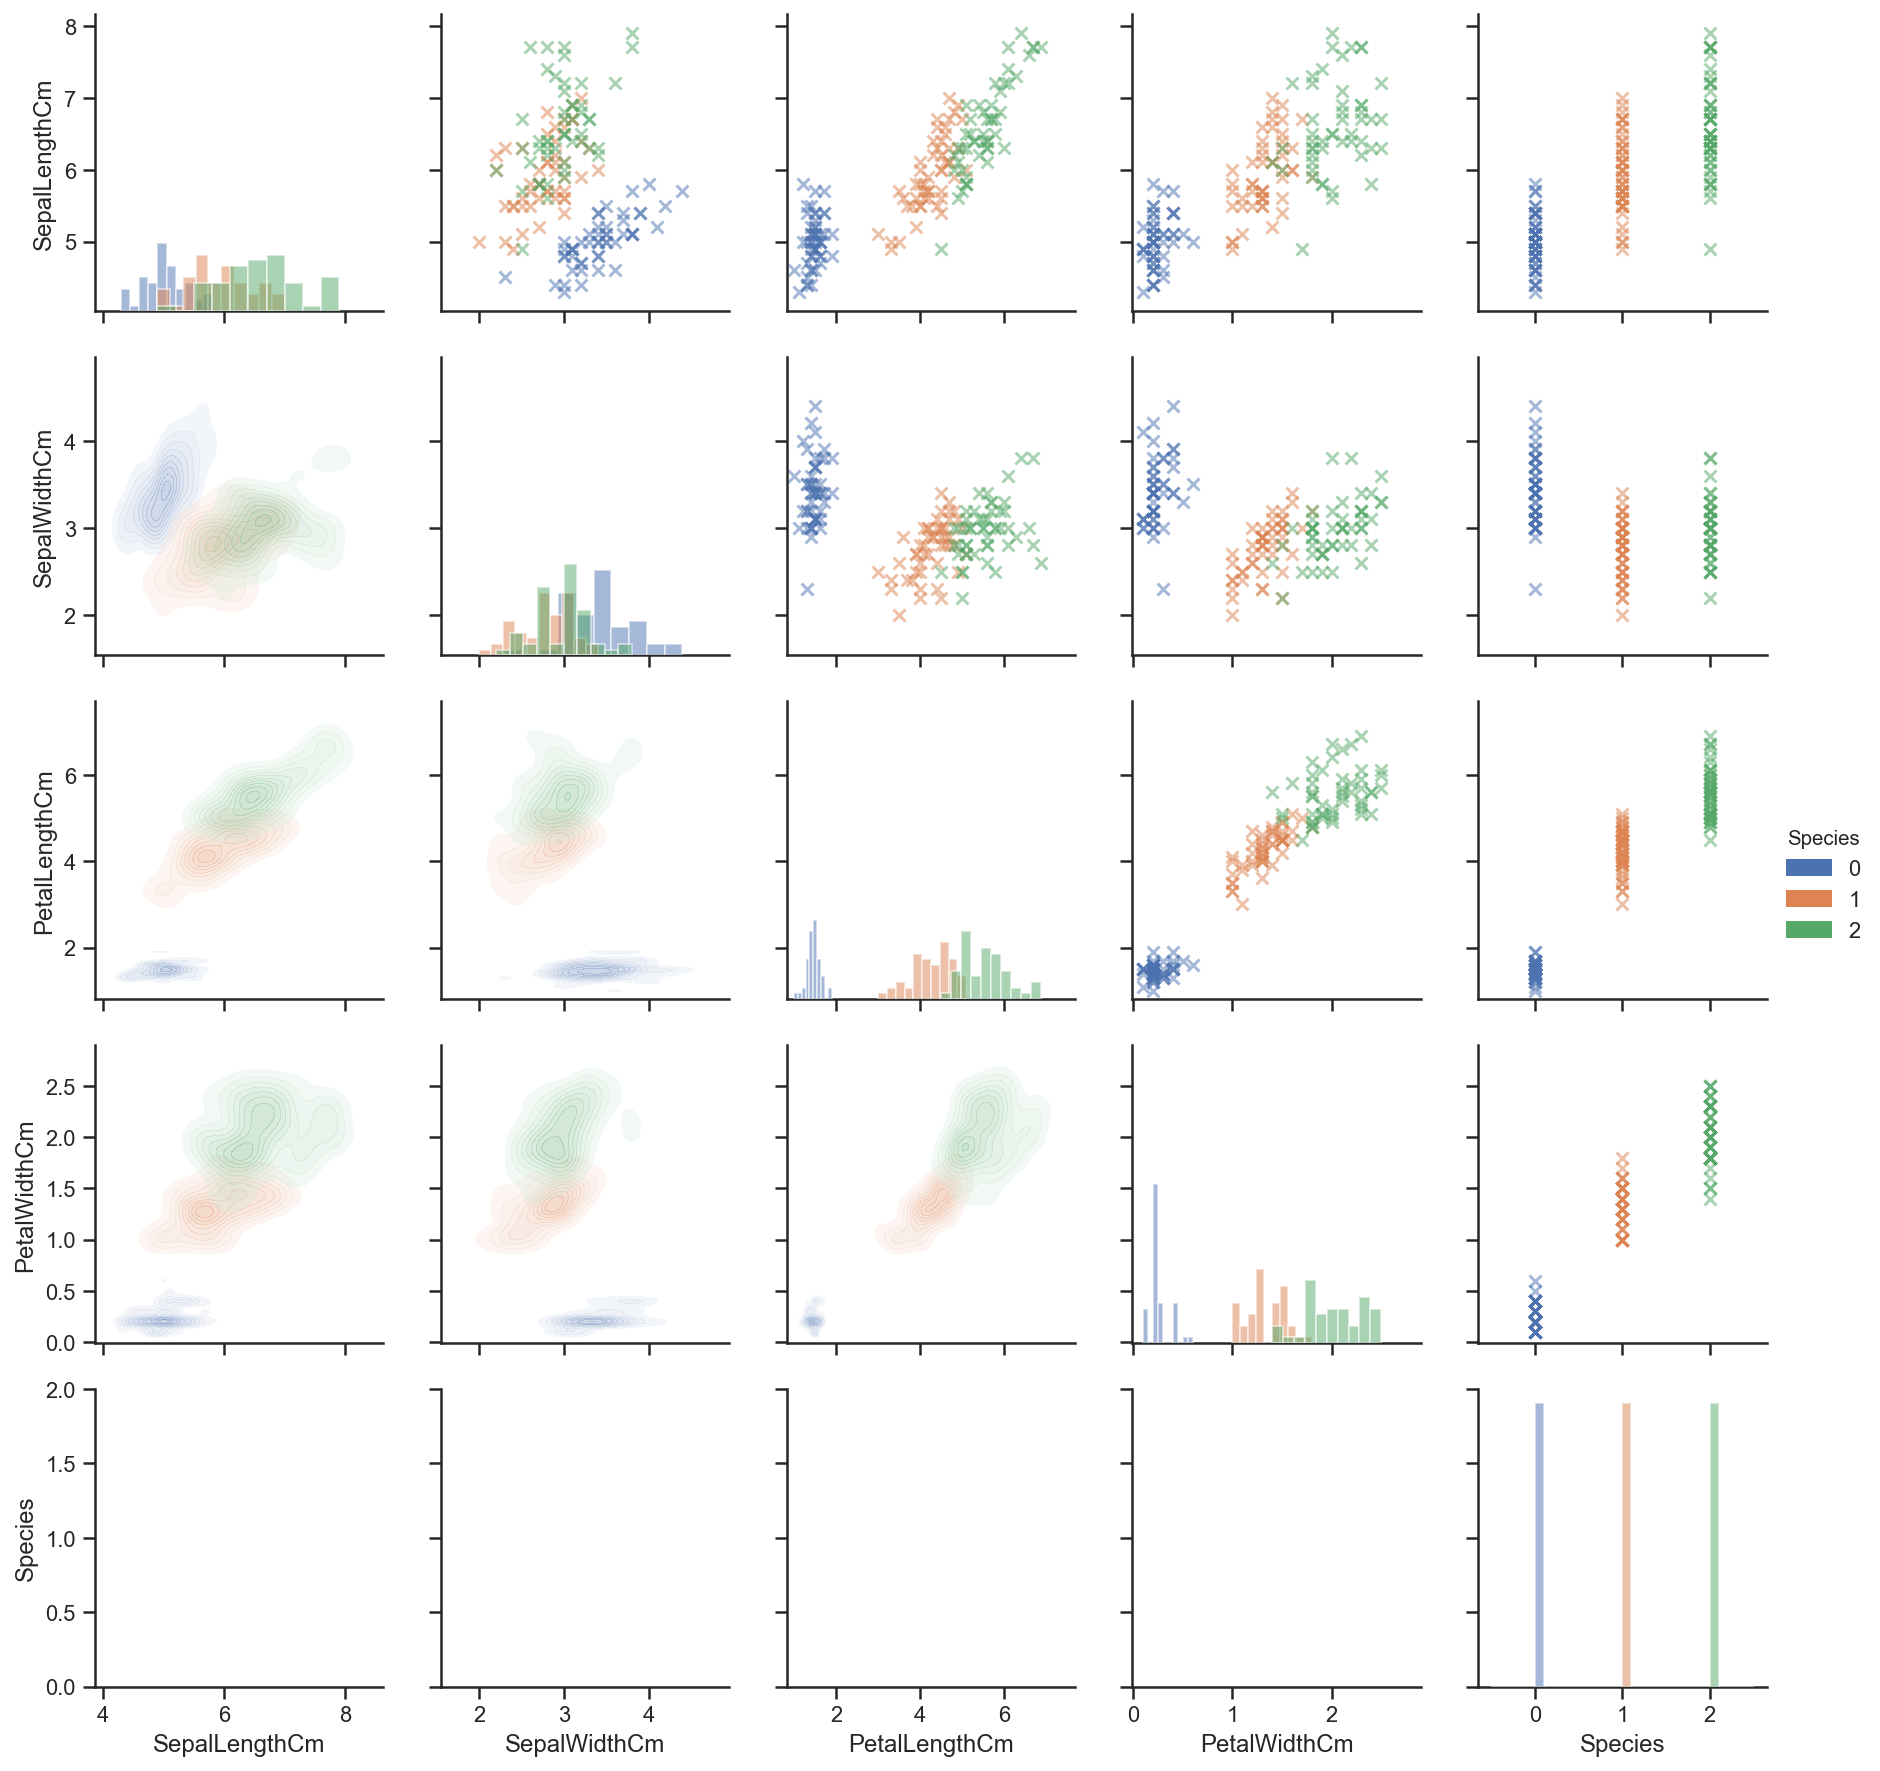

In [12]:
g = sns.PairGrid(data, hue="Species")
g.map_diag(plt.hist, alpha=0.5)
g.map_upper(plt.scatter, alpha=0.5, marker='x')
g.map_lower(sns.kdeplot, shade=True, shade_lowest=False, alpha=0.3)
g.add_legend();

Ящики с усами:

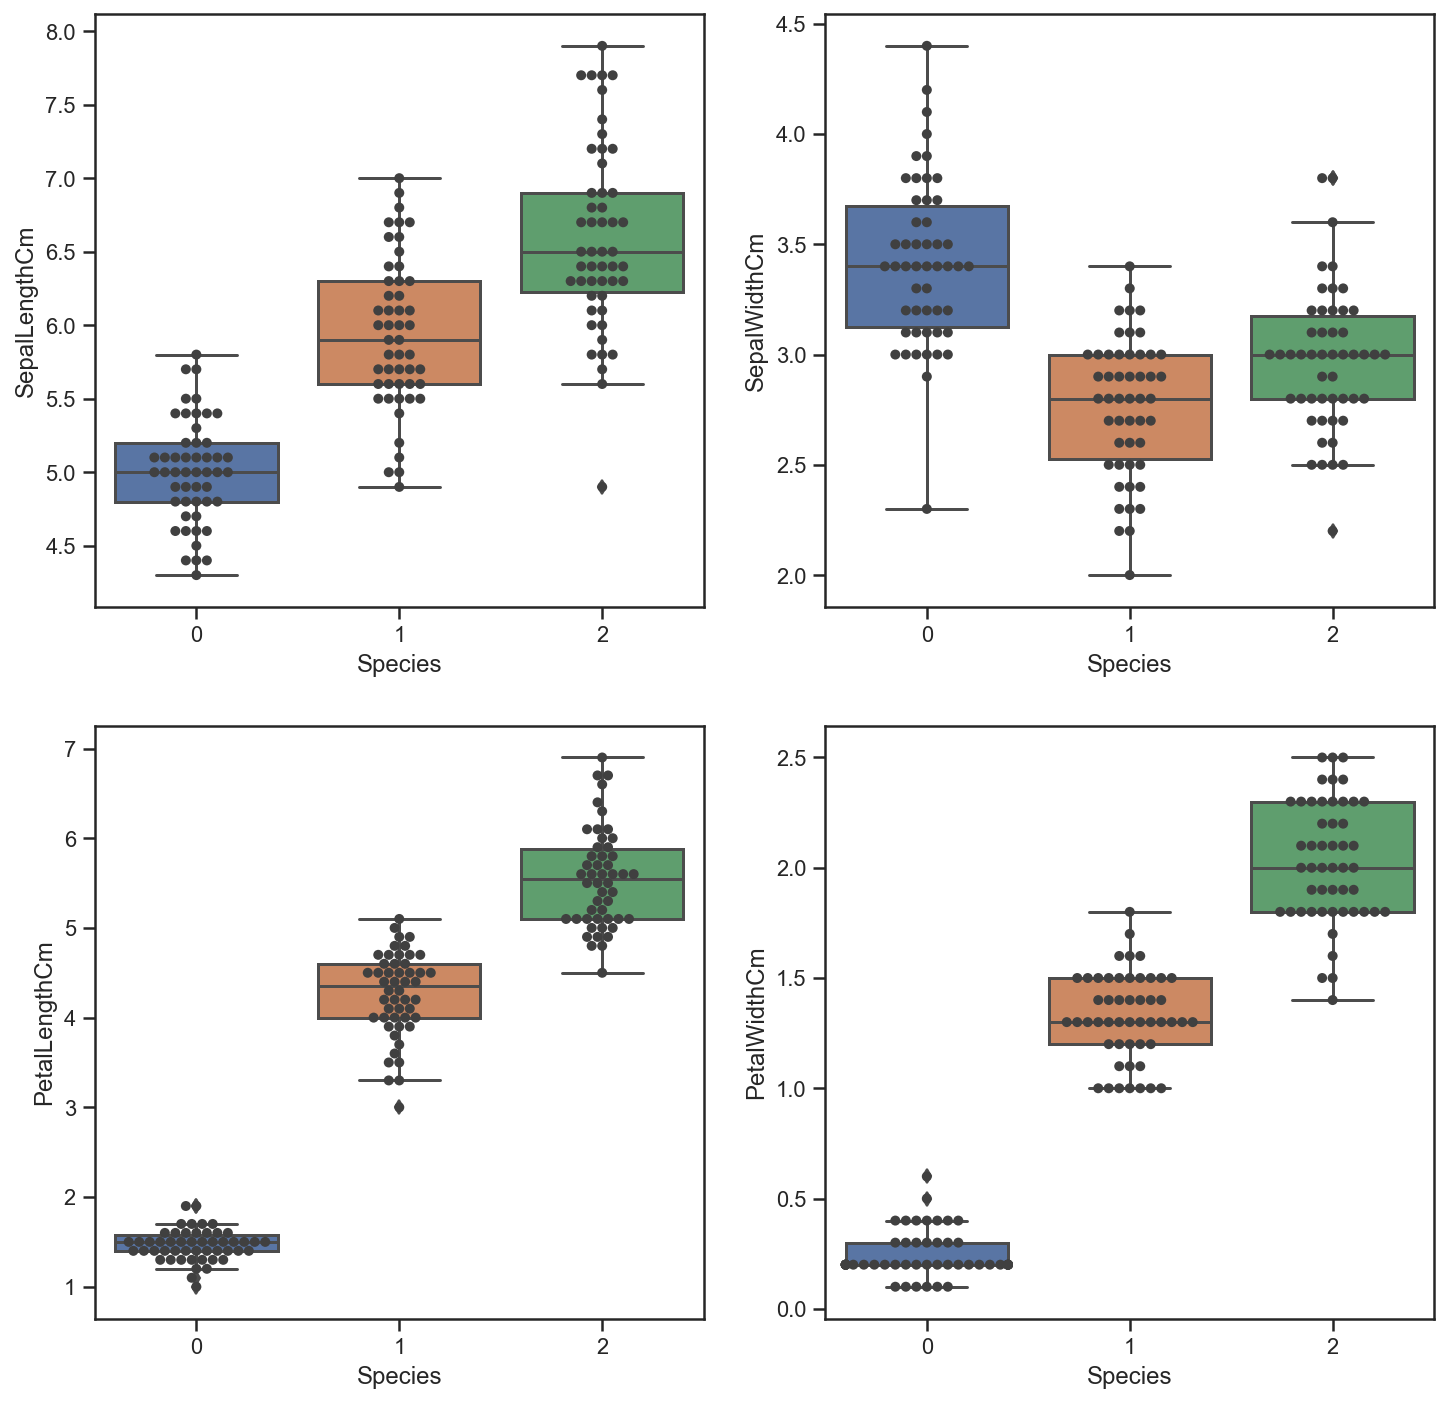

In [13]:
fig, axs = plt.subplots(ncols=2, nrows=2, figsize=(12, 12))

sns.boxplot(x="Species", y="SepalLengthCm", data=data, ax=axs[0, 0])
sns.swarmplot(x="Species", y="SepalLengthCm", data=data, color=".25",
              ax=axs[0, 0])

sns.boxplot(x="Species", y="SepalWidthCm", data=data, ax=axs[0, 1])
sns.swarmplot(x="Species", y="SepalWidthCm", data=data, color=".25",
              ax=axs[0, 1])

sns.boxplot(x="Species", y="PetalLengthCm", data=data, ax=axs[1, 0])
sns.swarmplot(x="Species", y="PetalLengthCm", data=data, color=".25",
              ax=axs[1, 0])

sns.boxplot(x="Species", y="PetalWidthCm", data=data, ax=axs[1, 1])
sns.swarmplot(x="Species", y="PetalWidthCm", data=data, color=".25",
              ax=axs[1, 1])

## Метрики качества кластеризации

1) [Adjusted Rand index](https://en.wikipedia.org/wiki/Rand_index)

Метрика применяется в том случае, если известны истинные метки классов. Для вычисления метрики используется функция [adjusted_rand_score.](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.adjusted_rand_score.html) Отчасти метрика напоминает accuracy, так как сравнивает полученные метки классов с известными истинными классами.

Метрика возвращает результат в диапазоне [-1;+1]. Значение близкое к +1 говорит об очень хорошем качестве кластеризации. Значение близкое к 0 соответствует случайным разбиениям. Отрицательные значения говорят о плохом качестве кластеризации.

2) [Adjusted Mutual Information](https://en.wikipedia.org/wiki/Adjusted_mutual_information)

Для вычисления метрики используется функция [adjusted_mutual_info_score.](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.adjusted_mutual_info_score.html)

Значение близкое к +1 говорит об очень хорошем качестве кластеризации. Значение близкое к 0 соответствует случайным разбиениям.

3) Homogeneity, completeness, V-measure

Для вычисления метрик используется функция [homogeneity_completeness_v_measure.](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.homogeneity_completeness_v_measure.html)

- Homogeneity - каждый кластер содержит только представителей единственного класса (под классом понимается истинное значение метки кластера). Значение в диапазоне [0;1], 1 говорит об очень хорошем качестве кластеризации.
- Completeness - все элементы одного класса помещены в один и тот же кластер. Значение в диапазоне [0;1], 1 говорит об очень хорошем качестве кластеризации.
- V-measure - [среднее гармоническое](https://ru.wikipedia.org/wiki/%D0%A1%D1%80%D0%B5%D0%B4%D0%BD%D0%B5%D0%B5_%D0%B3%D0%B0%D1%80%D0%BC%D0%BE%D0%BD%D0%B8%D1%87%D0%B5%D1%81%D0%BA%D0%BE%D0%B5) от Homogeneity и Completeness.

4) Коэффициент силуэта

Для вычисления метрики используется функция [silhouette_score](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.silhouette_score.html)

Данный метод не требует знания истинных значений меток кластеров.

Пусть:

- $a$ - среднее расстояние между текущей точкой и другими точками этого же кластера.
- $b$ - среднее расстояние между текущей точкой и другими точками следующего ближайшего кластера.

Тогда коэффициент силуэта для точки (объекта) определяется как:

$$ s = \frac{b-a}{max(a,b)} $$

Силуэтом выборки называется средняя величина силуэта объектов данной выборки. Таким образом, силуэт показывает, насколько среднее расстояние до объектов своего кластера отличается от среднего расстояния до объектов других кластеров. Данная величина лежит в диапазоне [-1;1]. Значения, близкие к -1, соответствуют плохим (разрозненным) кластеризациям, значения, близкие к нулю, говорят о том, что кластеры пересекаются и накладываются друг на друга, значения, близкие к 1, соответствуют "плотным" четко выделенным кластерам. Таким образом, чем больше силуэт, тем более четко выделены кластеры, и они представляют собой компактные, плотно сгруппированные облака точек.

С помощью силуэта можно выбирать оптимальное число кластеров
(если оно заранее неизвестно) — выбирается число кластеров, максимизирующее значение силуэта. В отличие от предыдущих метрик, силуэт зависит от формы кластеров, и достигает больших значений на более выпуклых кластерах, получаемых с помощью алгоритмов, основанных на восстановлении плотности распределения.

Будем использовать все вышеперечисленные метрики. Для этого напишем следующую функцию:

In [14]:
def claster_metrics(method, cluster_dataset, cluster_true_y,
                    dataset_name):
    ari = []
    ami = []
    hl = []
    cl = []
    vl = []
    sl = []

    temp_cluster = method.fit_predict(cluster_dataset)
    ari.append(adjusted_rand_score(cluster_true_y, temp_cluster))
    ami.append(adjusted_mutual_info_score(cluster_true_y, temp_cluster))
    
    h, c, v = homogeneity_completeness_v_measure(cluster_true_y,
                                                 temp_cluster)
    hl.append(h)
    cl.append(c)
    vl.append(v)

    sl.append(silhouette_score(cluster_dataset, temp_cluster))
    
    result = pd.DataFrame({'Datasets':dataset_name, 
                           'ARI':ari, 'AMI':ami, 
                           'Homogeneity':hl, 
                           'Completeness':cl, 
                           'V-measure':vl, 'Silhouette':sl})
    return result

## K-Means

In [15]:
claster_metrics(KMeans(n_clusters=3),
                data[['SepalLengthCm', 'SepalWidthCm',
                      'PetalLengthCm', 'PetalWidthCm']],
                data['Species'], 'iris')

,Datasets,ARI,AMI,Homogeneity,Completeness,V-measure,Silhouette
0,iris,0.730238,0.748372,0.751485,0.764986,0.758176,0.552592


## DBSCAN

In [16]:
claster_metrics(DBSCAN(eps=0.9), 
                data[['SepalLengthCm', 'SepalWidthCm',
                      'PetalLengthCm', 'PetalWidthCm']],
                data['Species'], 'iris')

,Datasets,ARI,AMI,Homogeneity,Completeness,V-measure,Silhouette
0,iris,0.568116,0.576771,0.57938,1.0,0.73368,0.686393


## Birch

In [17]:
claster_metrics(Birch(),
                data[['SepalLengthCm', 'SepalWidthCm',
                      'PetalLengthCm', 'PetalWidthCm']],
                data['Species'], 'iris')

,Datasets,ARI,AMI,Homogeneity,Completeness,V-measure,Silhouette
0,iris,0.609625,0.670611,0.674706,0.73836,0.705099,0.501699


## Выводы

В целом методы справились с задачей довольно хорошо. Лучше всех себя проявил метод `K-Means`. Методы `DBSCAN` и `Birch` справились с задачей чуть хуже. 